In [2]:
import os 
import transcript_data
import time
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F
import numpy as np
import glob
import importlib
import tcn
from pathlib import Path
import spliceAI
import matplotlib.pyplot as plt

checkpoint_path = Path("checkpoints_spliceAI64_BERT_predmeta") # this was trained with masking only (no 80/10/10 mask/cheat/corrupt)

n_epoch = len(list(checkpoint_path.glob("*.pt")))

def get_acc(fn): 
    a=torch.load(fn)
    return(a['train_loss'], 1.0 - a["train_acc"], a['test_loss'], 1.0 - a["test_acc"])

train_loss, train_acc, test_loss, test_acc = zip(*[ get_acc(checkpoint_path / ("%i.pt" % i)) for i in range(n_epoch) ])


In [12]:
a["test_loss"]

0.4007531315088272

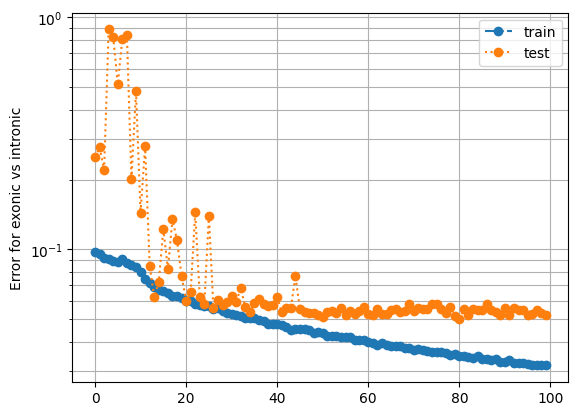

In [3]:
# doing a little better than mamba (0.948 acc vs 0.93)
plt.plot(train_acc,"-.o",label="train")
plt.plot(test_acc,":o",label="test")
plt.legend()
plt.yscale("log")
plt.ylabel("Error for exonic vs intronic")
plt.grid()
plt.grid(which="minor")
plt.show()

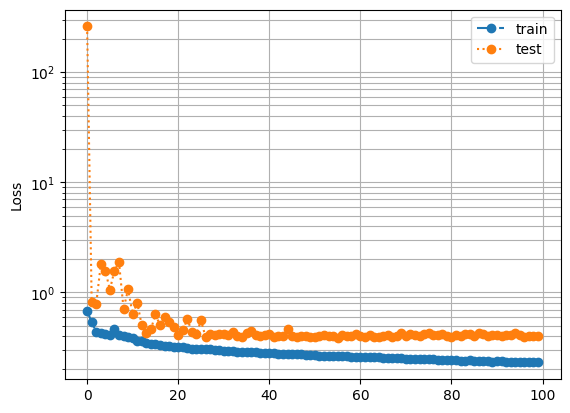

In [11]:
# this is a bit better for mamba: ~0.35 vs 0.4 here
plt.plot(train_loss,"-.o",label="train")
plt.plot(test_loss,":o",label="test")
plt.legend()
plt.ylabel("Loss")
plt.yscale("log")
plt.grid()
plt.grid(which="minor")
plt.show()

In [5]:
get_gene = transcript_data.get_generator(
    os.path.expanduser("~/knowles_lab/index/hg38/hg38.fa.gz"), 
    "gencode.v24.annotation.gtf.gz",
    "ENCFF191YXW.tsv.gz") # neural cell polyA RNA-seq

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = spliceAI.SpliceAI_10k(in_channels = 6, out_channels = 5, n_embed = 64).to(device)

checkpoint = torch.load(checkpoint_path / ("%i.pt" % (n_epoch-1)))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
# load a batch of test data to investigate
train_chroms = ["chr%i" % i for i in range(2,23)] + ["chrX"]
test_chroms = ["chr1"]

test_dataloader = transcript_data.get_dataloader(get_gene, test_chroms, receptive_field = 5000, batch_size = 5, device = device, max_len = 100000 )

rf = model.receptive_field
for ((is_exon, lengths_), (one_hot, lengths), weights) in test_dataloader: 

    one_hot = one_hot.permute(0, 2, 1) # convert to B x C x T
    is_exon = is_exon.permute(0, 2, 1)
    mask = is_exon.isnan()
    
    B,C,T = is_exon.shape # batch, channels, length

    meta = torch.zeros( B, 2, T + rf * 2, device = device)  # one hot, zero for missing
    meta[:, 0, rf:-rf] = is_exon[:,0,:]
    meta[:, 1, rf:-rf] = (1.-is_exon[:,0,:])

    input = torch.concat( (meta, one_hot), 1)

    output = model(input.nan_to_num()) # spliceAI uses conv which want B x C x T

    eval_mask = ~mask[:,0,:] # masked and not actually missing
    is_exon_masked = is_exon[:,0,:][ eval_mask ]
    output_masked = output[:,0,:][ eval_mask ]
    
    break

(is_exon_masked > 0.5).eq( output_masked > 0. ).float().mean().item()


0.9999524354934692

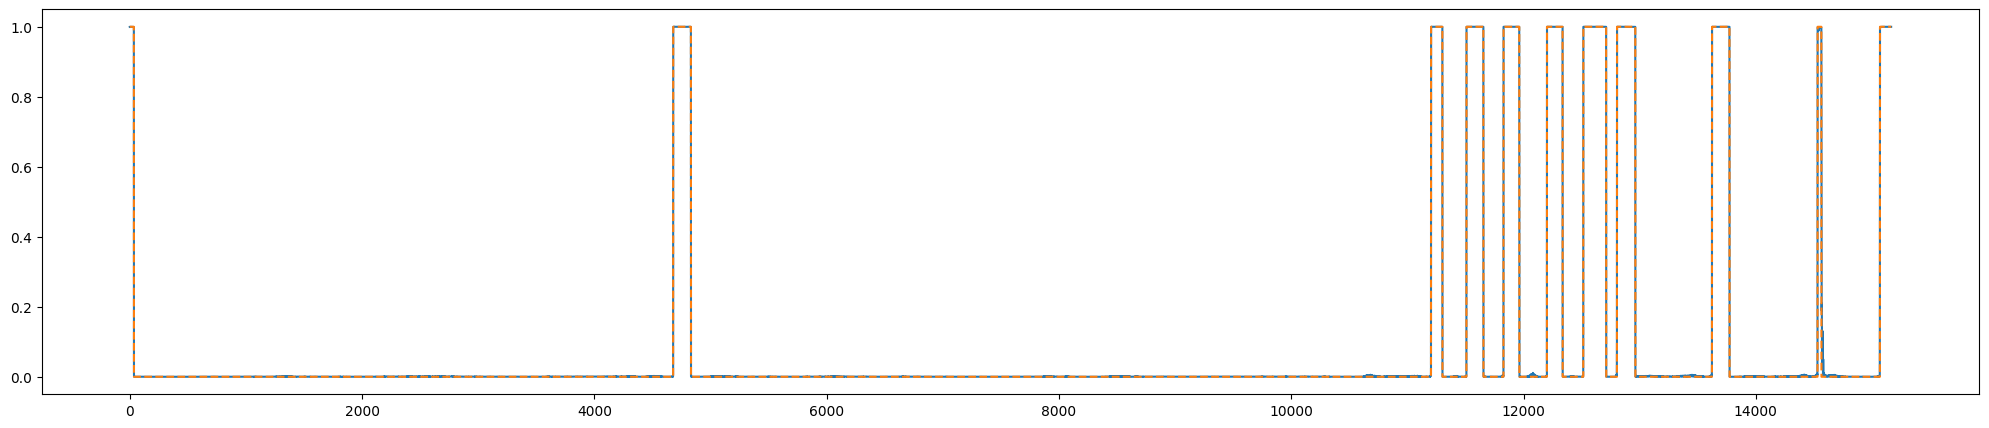

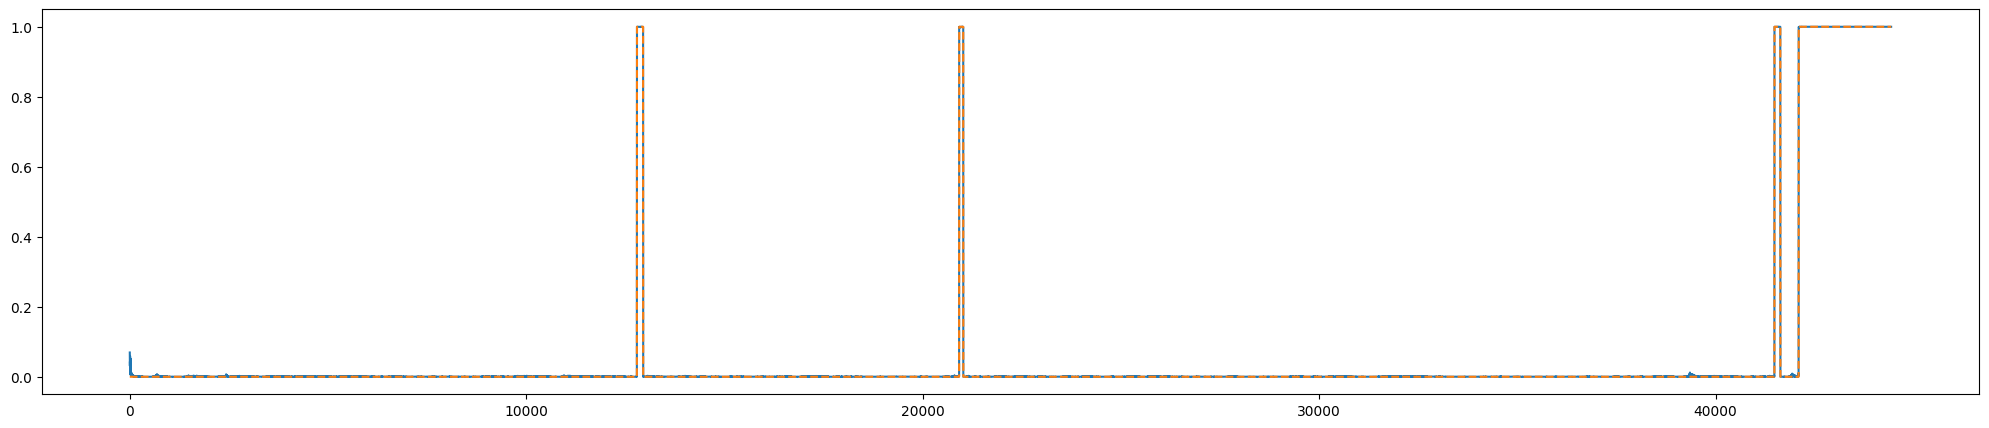

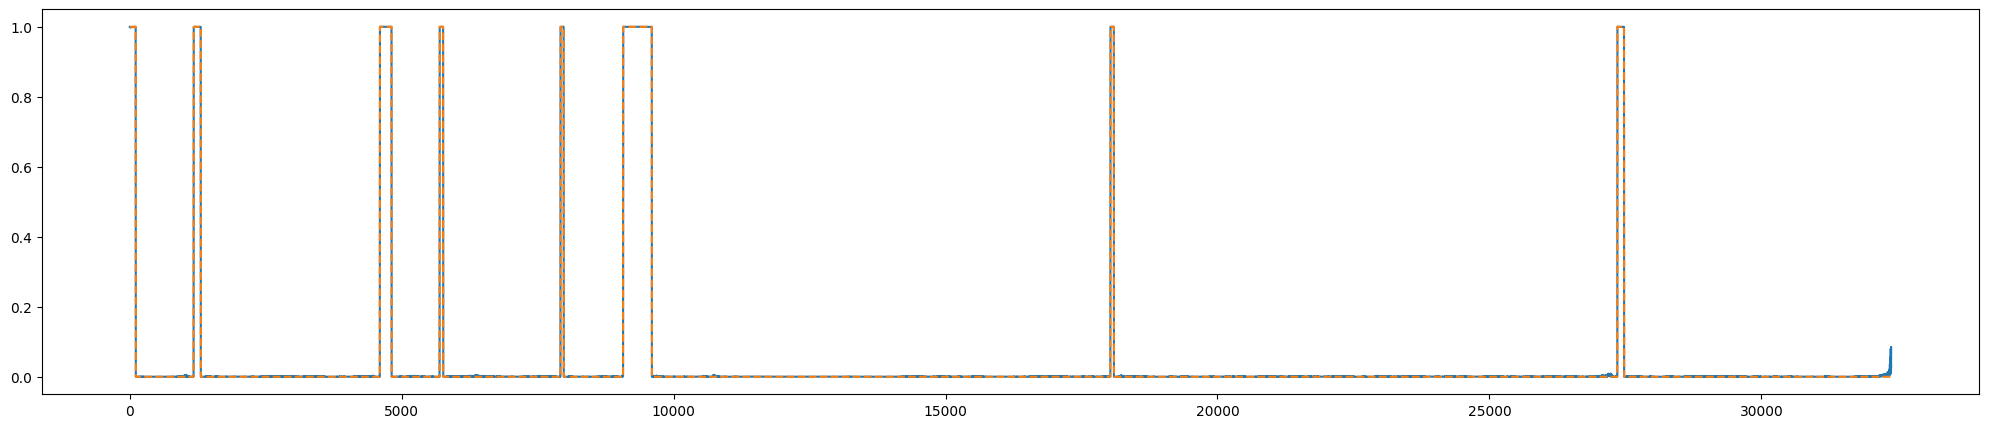

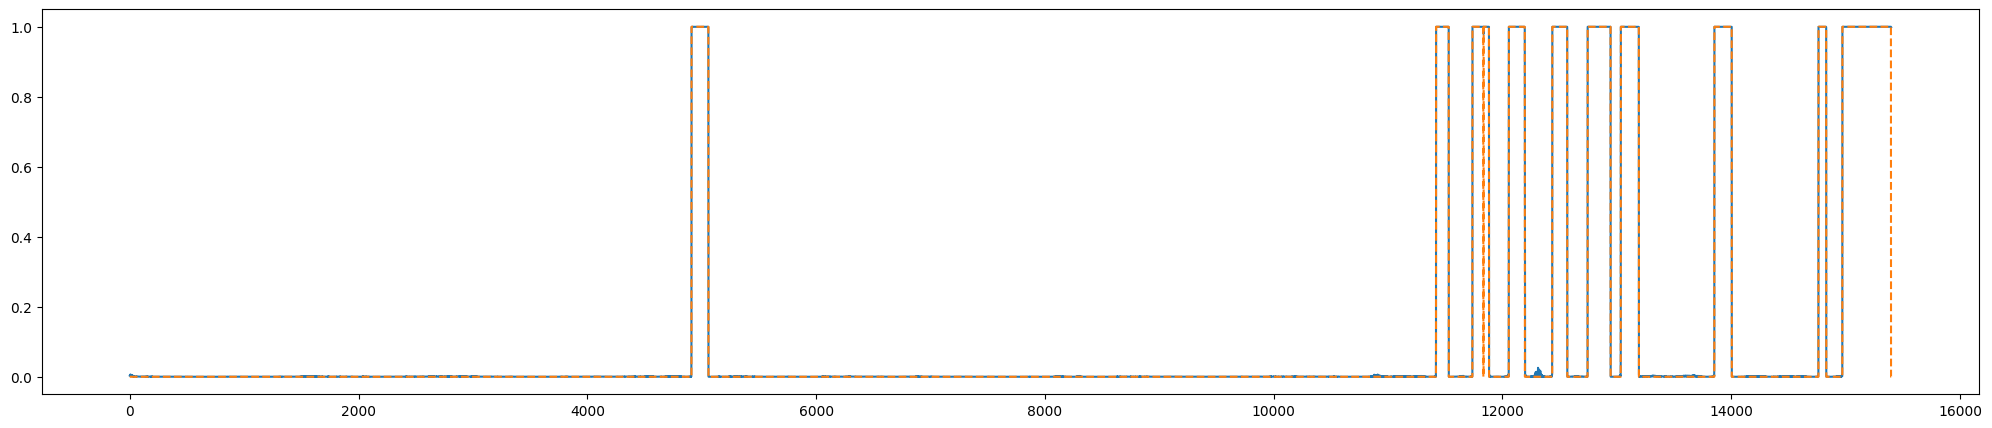

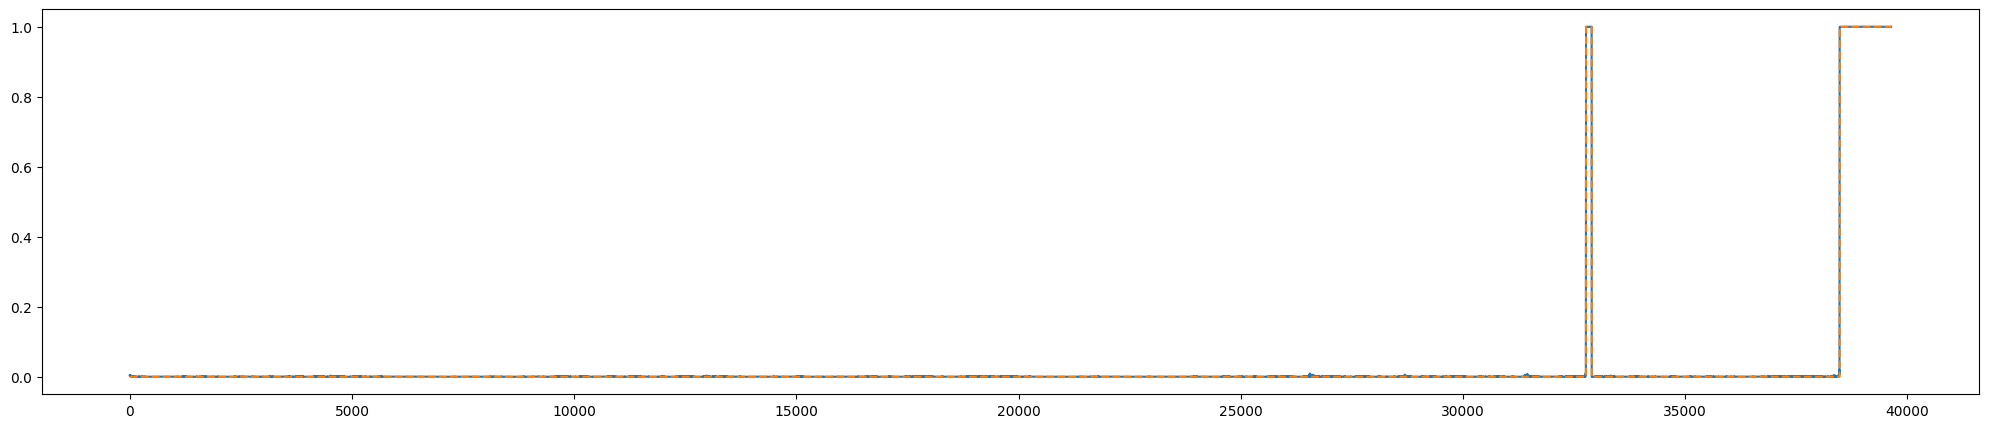

In [7]:
# with KNOWN meta, predictions are very good (but this is cheating!) 
for i in range(5): 
    plt.figure(figsize = (25,5))
    plt.plot(output[i,0,:][ ~mask[i,0,:] ].sigmoid().detach().cpu().numpy())
    plt.plot( is_exon[i,0,:].cpu().numpy(), "--" )
    plt.show()

In [8]:
# when meta is missing performance is better than random but not great
# this is equivalent to just predicting is_exonic from seq, but does worse than regular supervised learning
# maybe need longer spans? 80/10/10 is helping some. maybe just add this as a training task? 
input = torch.concat( (meta * 0., one_hot), 1)
output = model(input.nan_to_num())

output_masked = output[:,0,:][ eval_mask ]
(is_exon_masked > 0.5).eq( output_masked > 0. ).float().mean().item()

0.848767876625061

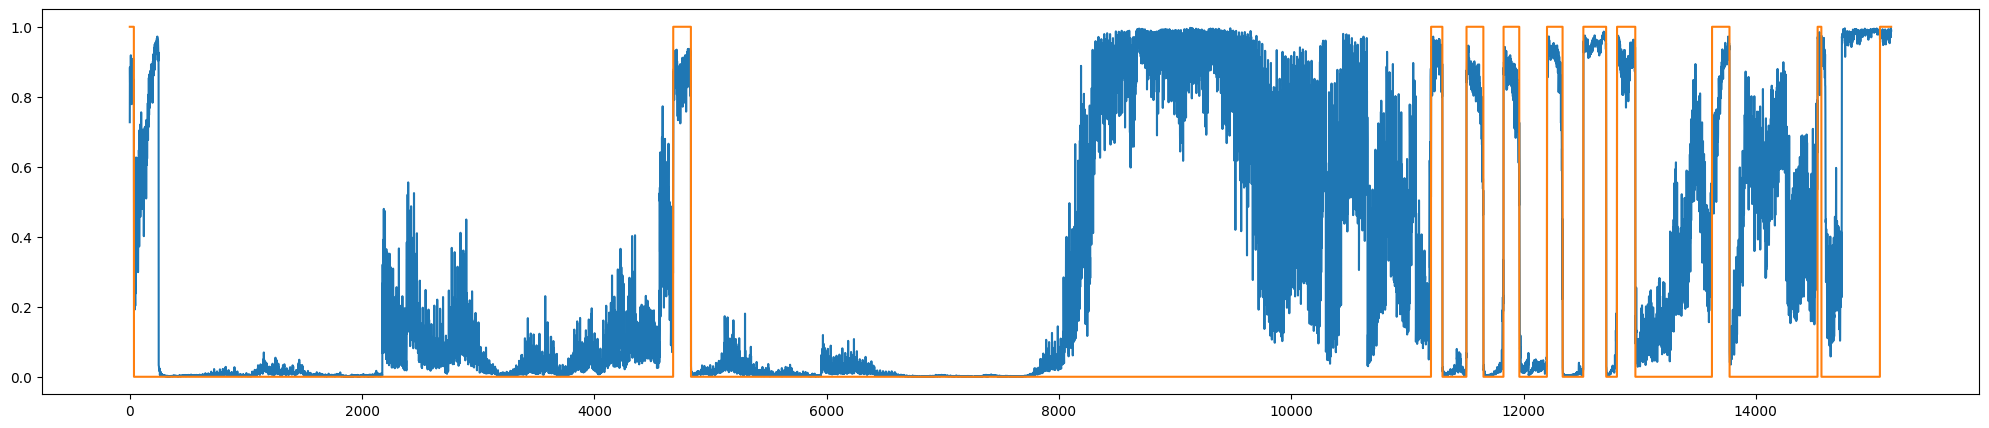

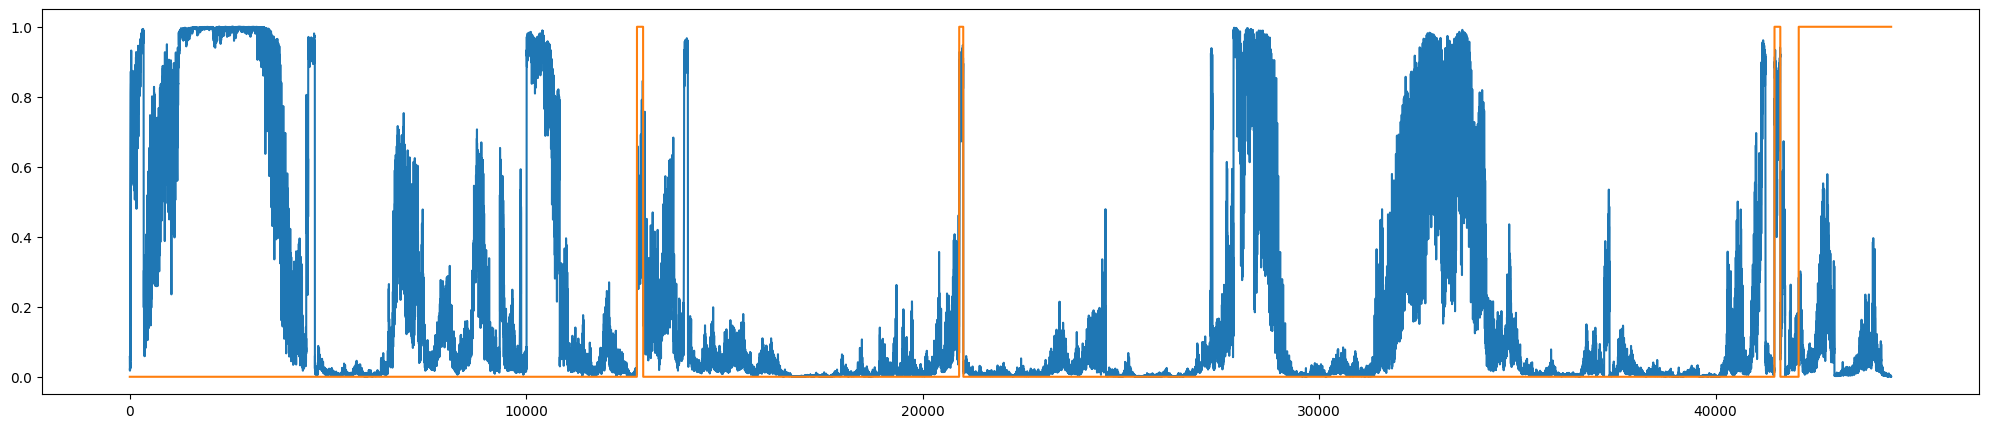

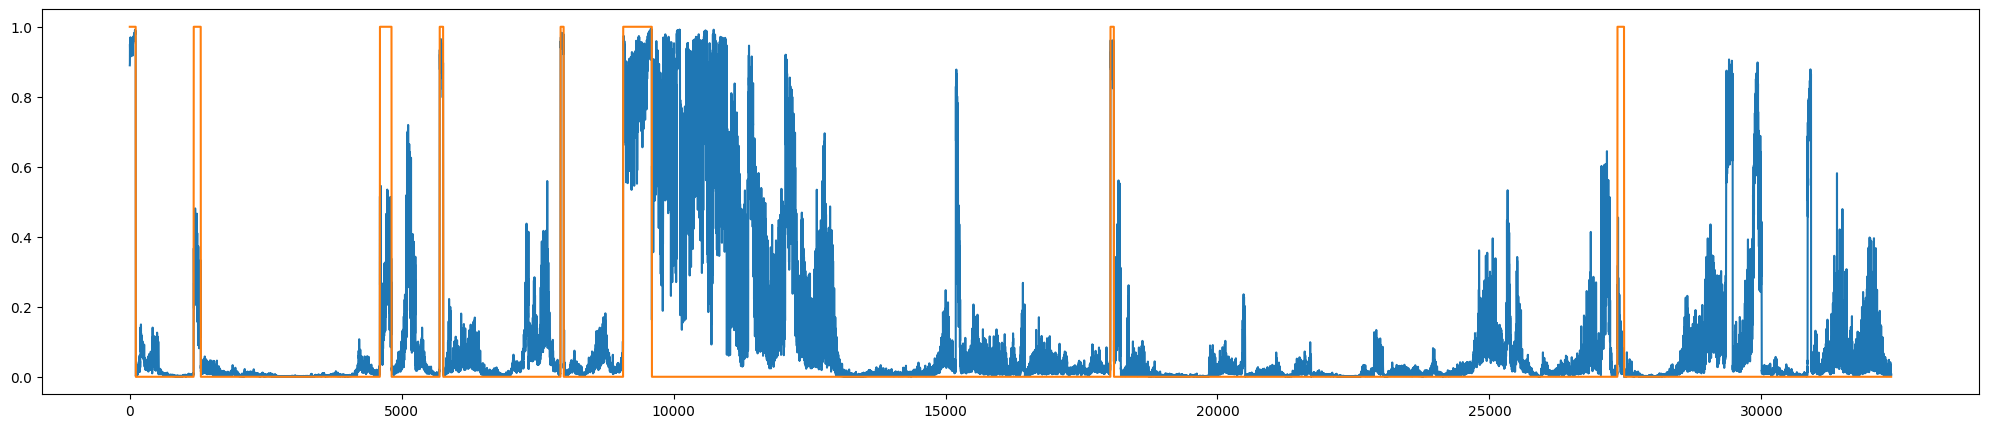

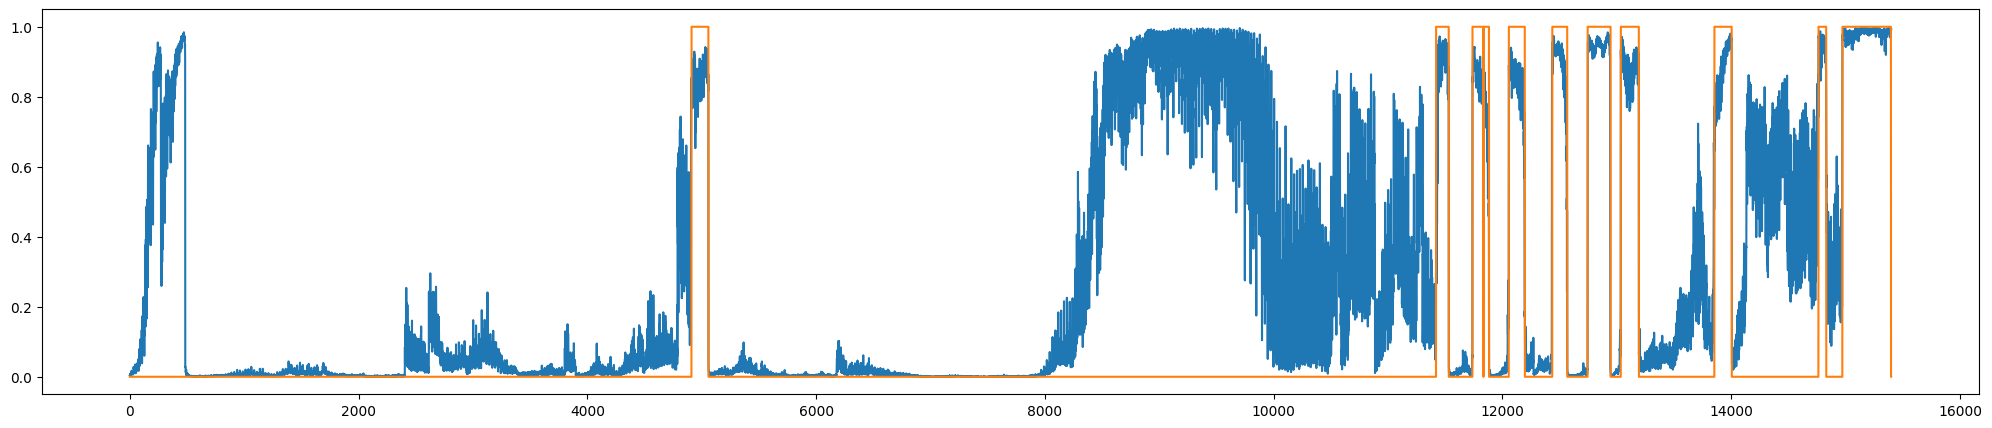

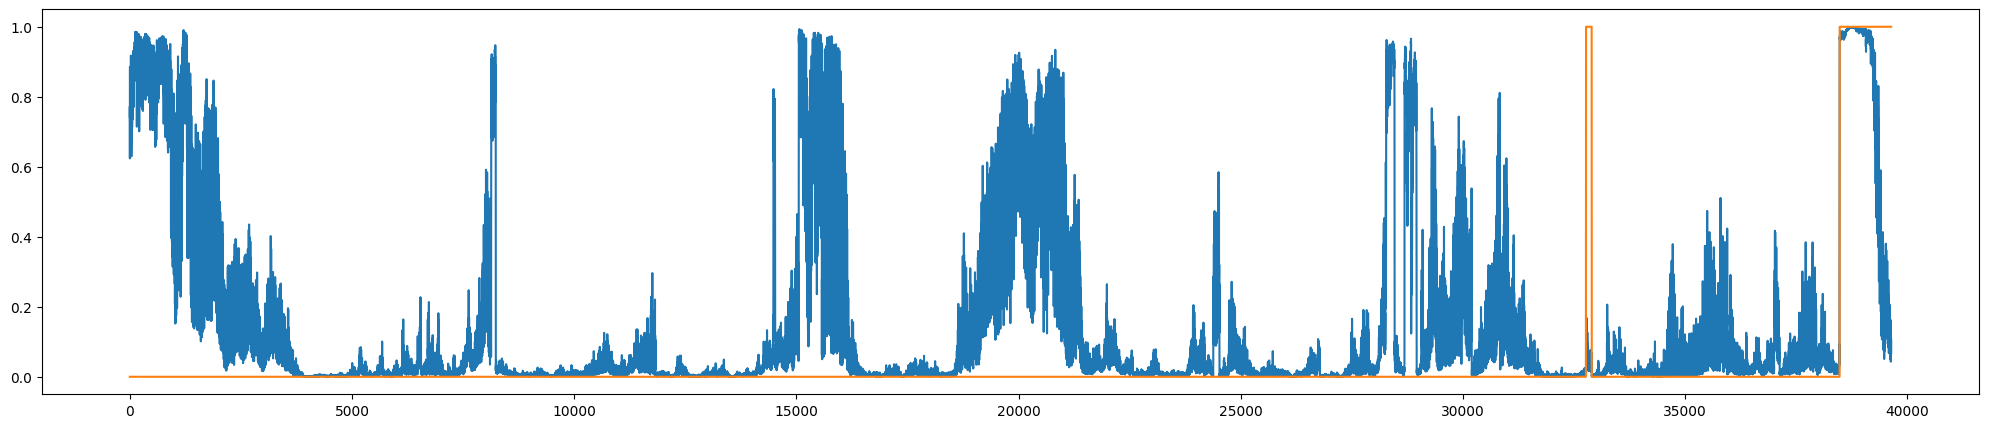

In [9]:
for i in range(5): 
    plt.figure(figsize = (25,5))
    plt.plot(output[i,0,:][ ~mask[i,0,:] ].sigmoid().detach().cpu().numpy())
    plt.plot( is_exon[i,0,:].cpu().numpy() )
    plt.show()

In [ ]:
import train
importlib.reload(train)

test_dataloader = transcript_data.get_dataloader(get_gene, test_chroms, receptive_field = 5000, batch_size = 5, device = device, max_len = 100000 )

metrics = train.one_epoch(model, test_dataloader, optimizer = None, device = device, pred_meta_task = True, eval_LM = True)

# when meta is missing performance is a little better than 80/10/10, but MLM performance is horrible
np.mean(seq_losses_no_context), np.mean(seq_losses_with_context), np.mean(accs), np.mean(baseline_acc) 